In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from pathlib import Path

## single model

In [16]:
model = 3
workdir = Path(f'work/chaos/lorenz{model}')
if not workdir.exists():
    workdir.mkdir(parents=True)

### model


In [17]:
from model.lorenz import L96
from model.lorenz2 import L05II
from model.lorenz3 import L05III

if model == 1:
    # Lorenz I
    nx = 40
    F = 8.0
    h = 0.05
    step = L96(nx,h,F)
elif model == 2:
    # Lorenz II
    nx = 240
    nk = 8
    h = 0.05
    F = 10.0
    step = L05II(nx,nk,h,F)
elif model==3:
    # Lorenz III
    nx = 960
    nk = 32
    ni = 12
    b = 10.0
    c = 0.6
    h = 0.05 / b
    F = 15.0
    step = L05III(nx,nk,ni,b,c,h,F)

ni=12 alpha=0.124 beta=0.014
nx=960 nk=32
F=15.0 dt=5.000e-03
b=10.0 c=0.6


### observation operator

In [18]:
from analysis.obs import Obs
obs = Obs('linear',1.0)

2024-02-07 12:12:41,929 anl INFO operator=linear, obserr=1.0
2024-02-07 12:12:41,930 anl INFO nvars=1


### analysis method

In [19]:
from analysis.envar import EnVAR
ne = 30
analysis = EnVAR(nx,ne,obs)

2024-02-07 12:12:41,933 anl INFO model : model
2024-02-07 12:12:41,934 anl INFO ndim=960 nmem=30
2024-02-07 12:12:41,934 anl INFO pt=envar op=linear sig=1.0 infl_parm=1.0 lsig=-1.0
2024-02-07 12:12:41,934 anl INFO linf=False iloc=None ltlm=False incremental=True


### truth and initial ensemble

In [20]:
z0 = np.zeros(nx)
z0[nx//2] += F*0.01
for i in range(100*int(0.05/h)):
    z0 = step(z0)
ne = 30
z0e = np.zeros((nx,ne))
for j in range(ne):
    z0e[:,j] = z0[:]
    z0e[:,j] = z0[:] + np.random.randn(nx)*0.1

In [21]:
phi = np.linspace(0.0,2.0*np.pi,nx+1)
x = np.cos(phi)
y = np.sin(phi)

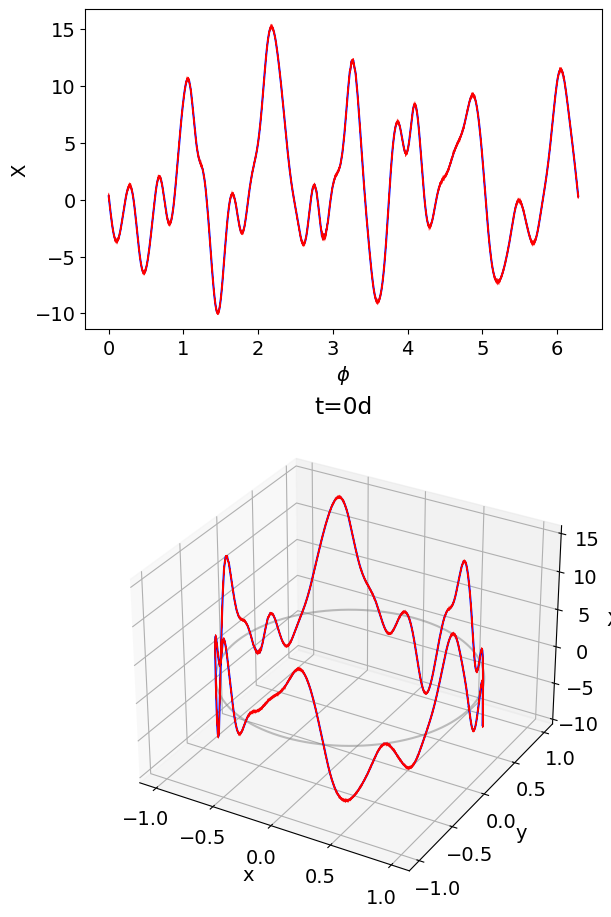

In [22]:
zb = np.hstack((z0,[z0[0]]))
zbe = np.vstack((z0e,z0e[0].reshape(1,-1)))
t=0.0
fig = plt.figure(figsize=[6,9],constrained_layout=True)
gs0 = gridspec.GridSpec(5,1,figure=fig)
ax0 = fig.add_subplot(gs0[:2,:])
ax1 = fig.add_subplot(gs0[2:,:],projection='3d')
ax0.set_xlabel(r'$\phi$')
ax0.set_ylabel('X')
ax1.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_zlabel('X')
labels = []
lines = []
ax0.plot(phi,zb,c='b',lw=1.5)
ax1.plot(x,y,zb,c='b',lw=1.5)
labels.append('truth')
lines.append(Line2D([0],[0],color='b',lw=1.5))
for i in range(zbe.shape[1]):
    #c = cmap(i)
    c = 'r'
    ax0.plot(phi,zbe[:,i],c=c,lw=0.5,alpha=0.5)
    ax1.plot(x,y,zbe[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('ensemble forecast')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
ax1.set_title(f't={int(t/0.05/4)}d')
plt.show()

### settings

In [23]:
nt6h = int(0.05/h)
ntmax = nt6h * 4 * 30
nstanl = nt6h * 4 * 5 # assimilation start
zt = []
ze = []
za = []
zt.append(z0)
ze.append(z0e)
za.append(z0e)

In [24]:
z0a = z0e.copy()
for i in range(ntmax):
    t += h
    z0 = step(z0)
    z0e = step(z0e)
    z0a = step(z0a)
    if i % nt6h == 0:
        if i >= nstanl:
            obsloc = np.arange(0,nx,2)
            yobs = obs.add_noise(obs.h_operator(obsloc,z0))
            z0a,_,_,_,_,_ = analysis(z0a,z0a,yobs,obsloc)
        zt.append(z0)
        ze.append(z0e)
        za.append(z0a)

2024-02-07 12:12:55,337 anl INFO set R
2024-02-07 12:12:55,451 anl INFO save_dh=False
2024-02-07 12:12:55,467 anl INFO method=CG
2024-02-07 12:12:55,468 anl INFO cgtype: Fletcher-Reeves
2024-02-07 12:12:55,471 anl INFO restart=False
2024-02-07 12:12:55,472 anl INFO save_hist=False
2024-02-07 12:12:55,475 anl INFO jb:0.000000e+00 jo:2.484133e+02
2024-02-07 12:12:55,481 anl INFO |dj|:4.145073e+00
2024-02-07 12:12:55,482 anl INFO jb:1.908410e-01 jo:2.445460e+02
2024-02-07 12:12:55,485 anl INFO |dj|:3.135073e+00
2024-02-07 12:12:55,485 anl INFO jb:3.214350e+00 jo:2.366081e+02
2024-02-07 12:12:55,488 anl INFO |dj|:5.024104e-15
2024-02-07 12:12:55,489 anl INFO success=True message=Optimization terminated successfully.
2024-02-07 12:12:55,489 anl INFO J=2.398e+02 dJ=5.024e-15 nit=1
2024-02-07 12:12:55,594 anl INFO zmat shape=(480, 30)
2024-02-07 12:12:55,598 anl INFO d shape=(480,)
2024-02-07 12:12:55,603 anl INFO converge gmat, iter_num=3, norm=5.275475123779068e-07
2024-02-07 12:12:55,608 a

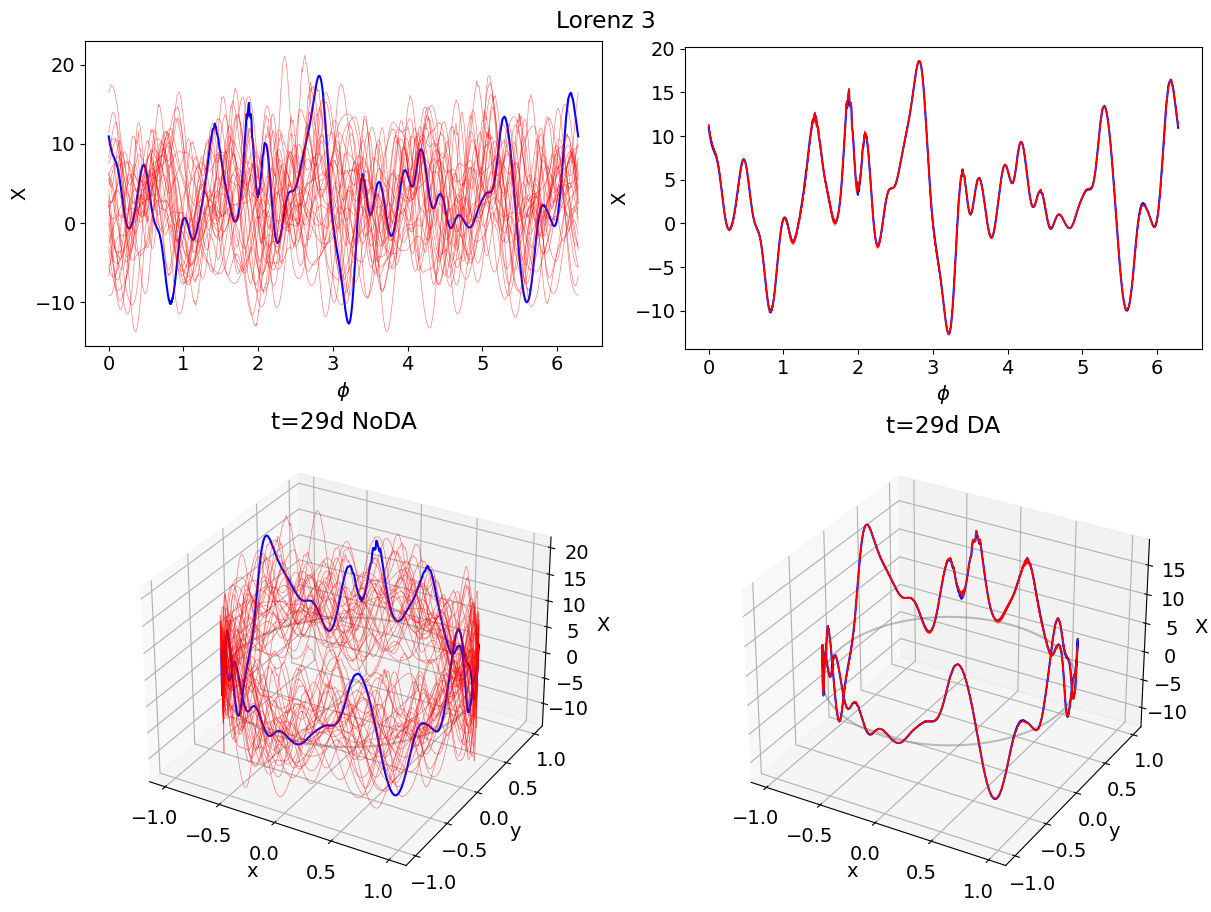

In [26]:
zb = np.hstack((z0,[z0[0]]))
zbe = np.vstack((z0e,z0e[0].reshape(1,-1)))
zba = np.vstack((z0a,z0a[0].reshape(1,-1)))
fig = plt.figure(figsize=[12,9],constrained_layout=True)
gs = gridspec.GridSpec(1,2,figure=fig)
gs0 = gs[0].subgridspec(5,1)
ax0 = fig.add_subplot(gs0[:2,:])
ax1 = fig.add_subplot(gs0[2:,:],projection='3d')
ax0.set_xlabel(r'$\phi$')
ax0.set_ylabel('X')
ax1.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_zlabel('X')
gs1 = gs[1].subgridspec(5,1)
ax2 = fig.add_subplot(gs1[:2,:])
ax3 = fig.add_subplot(gs1[2:,:],projection='3d')
ax2.set_xlabel(r'$\phi$')
ax2.set_ylabel('X')
ax3.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
#ax3.set_xticklabels([])
#ax3.set_yticklabels([])
ax3.set_zlabel('X')
labels = []
lines = []
ax0.plot(phi,zb,c='b',lw=1.5)
ax1.plot(x,y,zb,c='b',lw=1.5)
ax2.plot(phi,zb,c='b',lw=1.5)
ax3.plot(x,y,zb,c='b',lw=1.5)
labels.append('truth')
lines.append(Line2D([0],[0],color='b',lw=1.5))
for i in range(zbe.shape[1]):
    #c = cmap(i)
    c = 'r'
    ax0.plot(phi,zbe[:,i],c=c,lw=0.5,alpha=0.5)
    ax1.plot(x,y,zbe[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('ensemble forecast')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
ax1.set_title(f't={int(t/0.05/4)}d NoDA')
for i in range(zba.shape[1]):
    #c = cmap(i)
    c = 'r'
    ax2.plot(phi,zba[:,i],c=c,lw=0.5,alpha=0.5)
    ax3.plot(x,y,zba[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('ensemble analysis')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
ax3.set_title(f't={int(t/0.05/4)}d DA')
fig.suptitle(f'Lorenz {model}')
fig.savefig(workdir/'chaos_da.png',dpi=300)
plt.show()

### animation

2024-02-07 17:13:04,589 matplotlib.animation INFO Animation.save using <class 'matplotlib.animation.PillowWriter'>


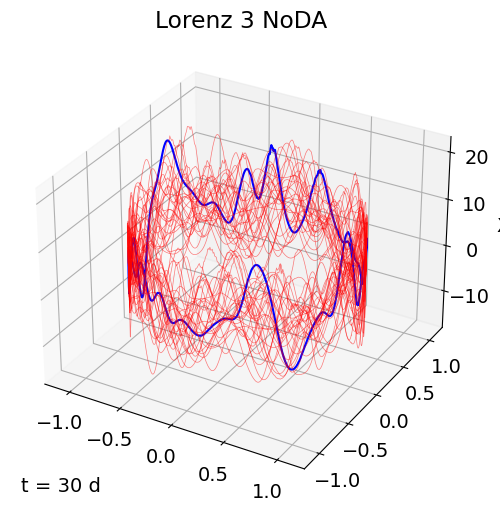

In [28]:
import matplotlib.animation as animation

zmin = np.min(np.array(zt))
zmax = np.max(np.array(zt))
fig= plt.figure(figsize=[6,6])
ax = fig.add_subplot(projection='3d',\
    autoscale_on=False,xlim=(-1.2,1.2),ylim=(-1.2,1.2),zlim=(zmin-0.1,zmax+0.1))
ax.set_zlabel('X')
ax.set_title(f'Lorenz {model} NoDA')
lines = []
truth, = ax.plot([],[],[],c='b',lw=1.5)
lines.append(truth)
for j in range(1,ne+1):
    ensfcst, = ax.plot([],[],[],c='r',lw=0.5,alpha=0.5)
    lines.append(ensfcst)
time_template = 't = %d d'
time_text = ax.text(0.05,0.9,0.9,'',transform=ax.transAxes)

def animate(i, zt, ze, lines):
    t=int(i*nt6h*h/0.05/4)
    zt0 = zt[i]
    ze0 = ze[i]
    zb = np.hstack((zt0,[zt0[0]]))
    zbe = np.vstack((ze0,ze0[0,:].reshape(1,-1)))
    for j, line in enumerate(lines):
        line.set_data(x,y)
        if j==0:
            line.set_3d_properties(zb)
        else:
            line.set_3d_properties(zbe[:,j-1])
    time_text.set_text(time_template % t)
    outlist = lines + [time_text]
    return outlist

ani = animation.FuncAnimation(fig, animate, len(ze),\
    fargs=(zt,ze,lines), interval=50)
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
ani.save(workdir/'chaos_noda.gif', writer=writer)

plt.show()

2024-02-07 17:19:38,795 matplotlib.animation INFO Animation.save using <class 'matplotlib.animation.PillowWriter'>


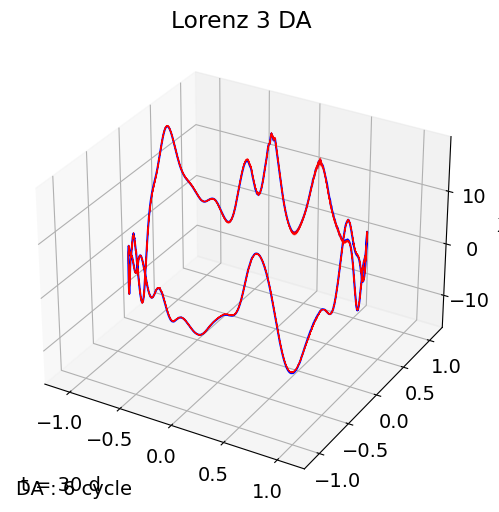

In [33]:
zmin = np.min(np.array(zt))
zmax = np.max(np.array(zt))
fig= plt.figure(figsize=[6,6])
ax = fig.add_subplot(projection='3d',\
    autoscale_on=False,xlim=(-1.2,1.2),ylim=(-1.2,1.2),zlim=(zmin-0.1,zmax+0.1))
ax.set_zlabel('X')
ax.set_title(f'Lorenz {model} DA')
lines = []
truth, = ax.plot([],[],[],c='b',lw=1.5)
lines.append(truth)
for j in range(1,ne+1):
    ensfcst, = ax.plot([],[],[],c='r',lw=0.5,alpha=0.5)
    lines.append(ensfcst)
time_template = 't = %d d'
time_text = ax.text(0.05,0.9,0.9,'',transform=ax.transAxes)
cycle_template = 'DA : %d cycle'
cycle_text = ax.text(0.05,0.9,0.5,'',transform=ax.transAxes)

def animate(i, zt, za, lines):
    t=int(i*nt6h*h/0.05/4)
    zt0 = zt[i]
    za0 = za[i]
    zb = np.hstack((zt0,[zt0[0]]))
    zba = np.vstack((za0,za0[0,:].reshape(1,-1)))
    for j, line in enumerate(lines):
        line.set_data(x,y)
        if j==0:
            line.set_3d_properties(zb)
        else:
            line.set_3d_properties(zba[:,j-1])
    time_text.set_text(time_template % t)
    outlist = lines + [time_text]
    if i*nt6h >= nstanl:
        icycle = i*nt6h // nstanl
        cycle_text.set_text(cycle_template % icycle)
        outlist = outlist + [cycle_text]
    return outlist

ani = animation.FuncAnimation(fig, animate, len(za),\
    fargs=(zt,za,lines), interval=50)
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
ani.save(workdir/'chaos_da.gif', writer=writer)

plt.show()